# NoteBook Projet TAI

# PARTIE : 0 : Setup initial

## Imports des lib et Chargement images

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
from glob import glob

%matplotlib inline

# Chemin vers les images
image_paths = glob("images/*.png") + glob("images/*.jpg") + glob("images/*.jpeg")

print("Nbr d'img chargee :", len(image_paths))
image_paths[:5] 


Nbr d'img chargee : 24


['images\\kodim01.png',
 'images\\kodim02.png',
 'images\\kodim03.png',
 'images\\kodim04.png',
 'images\\kodim05.png']

## Creation des dossier et fonction sauvegarde des images

In [2]:
folders = [
    # Base
    "results",
    "results/histograms",

    # Grayscale + Equalization
    "results/grayscale",
    "results/hist_equalization",
    "results/clahe",

    # Noise
    "results/noise",
    "results/noise/gaussian",
    "results/noise/salt_pepper",

    # Linear filters
    "results/filters",
    "results/filters/mean",
    "results/filters/gaussian",

    # Non-linear filters
    "results/filters/median",
    "results/filters/bilateral",
    "results/filters/nagao",

    # Morphology
    "results/morphology",
    "results/morphology/erosion",
    "results/morphology/dilation",
    "results/morphology/opening",
    "results/morphology/closing",
    "results/morphology/tophat",

    # Chaînes de traitement
    "results/chains",

    # Segmentation
    "results/segmentation",

    # Metrics (nouveau dossier pour stocker les fichiers .txt)
    "results/metrics",
]

In [3]:
# Creation des dossiers
for folder in folders:
    os.makedirs(folder, exist_ok=True)

def save_image(img, folder, filename):
    save_path = os.path.join("results", folder, filename)
    if len(img.shape) == 3:
        img_bgr = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        cv2.imwrite(save_path, img_bgr)
    else:
        cv2.imwrite(save_path, img)

    print("Image sauvegardee →", save_path)


# PARTIE : I : Fonction Principales

## Fonctions pour chargement et affichage des images avec histogramme

In [4]:
# -- Fonction pour charger + convertir en grayscale optionnel --
def load_image(path, gray=False):
    img = cv2.imread(path)
    if img is None:
        raise ValueError("Image introuvable :", path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # conversion pour Matplotlib
    if gray:
        return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    return img


# -- Fonction pour afficher une image + son histogramme --
def show_image_and_hist(img, gray=False):
    plt.figure(figsize=(12,5))

    # Image
    plt.subplot(1,2,1)
    cmap = "gray" if gray else None
    plt.imshow(img, cmap=cmap)
    plt.title("Image")
    plt.axis("off")

    # Histogramme
    plt.subplot(1,2,2)
    if gray:
        plt.hist(img.ravel(), bins=256, color='black')
        plt.title("Histogramme (gray)")
    else:
        colors = ('r','g','b')
        for i, col in enumerate(colors):
            plt.hist(img[:,:,i].ravel(), bins=256, color=col, alpha=0.5)
        plt.title("Histogramme RGB")
    plt.tight_layout()
    plt.show()


### Test sur la 1ere image

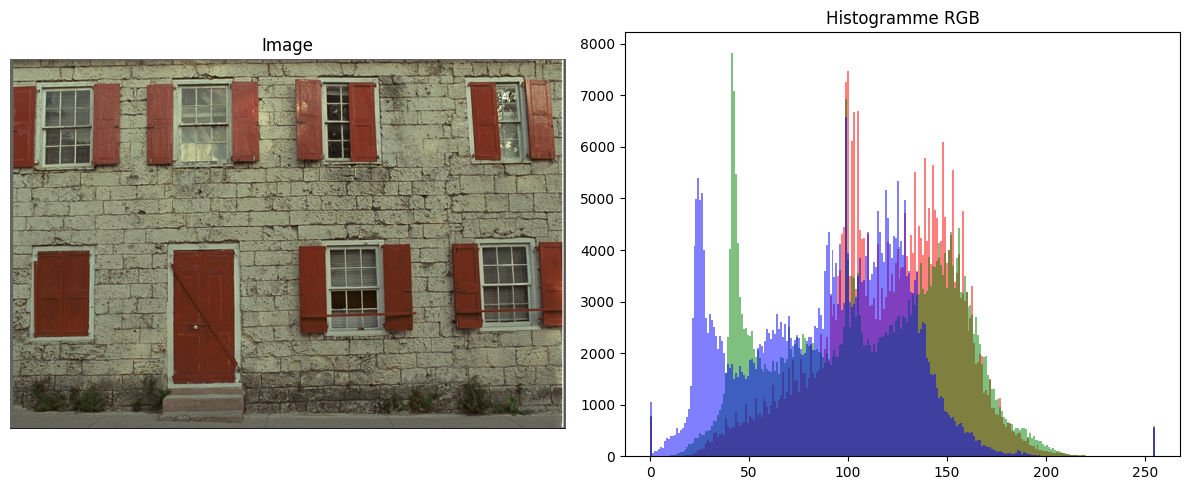

In [5]:
test_img_path = image_paths[0]
img = load_image(test_img_path, gray=False)

show_image_and_hist(img, gray=False)

filename = os.path.basename(test_img_path)

# Sauvegarde histogramme
plt.figure(figsize=(6,4))
colors = ('r','g','b')
for i, col in enumerate(colors):
    plt.hist(img[:,:,i].ravel(), bins=256, alpha=0.5)
plt.title("Histogram of Original Image")

hist_path = os.path.join("results", "histograms", "hist_" + filename)
plt.savefig(hist_path)
plt.close()


## Egalisation Histogramme et CLAHE

In [6]:
# -- Egalisation d'histogramme (gray scale) --
def histogram_equalization(img_gray):
    eq = cv2.equalizeHist(img_gray)
    return eq

# --CLAHE --
def clahe_equalization(img_gray, clip=3.0, tile=8):
    clahe = cv2.createCLAHE(clipLimit=clip, tileGridSize=(tile, tile))
    eq = clahe.apply(img_gray)
    return eq

### Test des methodes

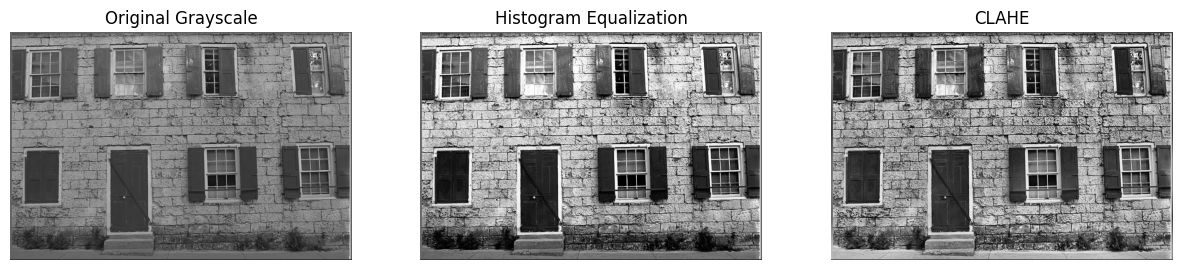

Image sauvegardee → results\grayscale\gray_kodim01.png
Image sauvegardee → results\hist_equalization\eq_kodim01.png
Image sauvegardee → results\clahe\clahe_kodim01.png


In [7]:
img_gray = load_image(test_img_path, gray=True)

eq = histogram_equalization(img_gray)
clahe = clahe_equalization(img_gray)

plt.figure(figsize=(15,5))

plt.subplot(1,3,1)
plt.imshow(img_gray, cmap='gray')
plt.title("Original Grayscale")
plt.axis("off")

plt.subplot(1,3,2)
plt.imshow(eq, cmap='gray')
plt.title("Histogram Equalization")
plt.axis("off")

plt.subplot(1,3,3)
plt.imshow(clahe, cmap='gray')
plt.title("CLAHE")
plt.axis("off")

plt.show()

# Sauvegarde des resultats

filename_gray = "gray_" + os.path.basename(test_img_path)
filename_eq = "eq_" + os.path.basename(test_img_path)
filename_clahe = "clahe_" + os.path.basename(test_img_path)

save_image(img_gray, "grayscale", filename_gray)
save_image(eq, "hist_equalization", filename_eq)
save_image(clahe, "clahe", filename_clahe)


# PARTIE : II : Fonction des filtres pour le traitment

## Fonction Bruit Gaussien

In [8]:
def add_gaussian_noise(img_gray, mean=0, var=0.01):
    sigma = var**0.5
    gaussian = np.random.normal(mean, sigma, img_gray.shape)
    noisy = img_gray + gaussian * 255
    noisy = np.clip(noisy, 0, 255).astype(np.uint8)
    return noisy

## Fonction Bruit Sel & Poivre

In [9]:
def add_salt_pepper_noise(img_gray, amount=0.02):
    noisy = img_gray.copy()
    num_pixels = img_gray.size

    # Sel (pixels blanc)
    num_salt = int(amount * num_pixels / 2)
    coords = [np.random.randint(0, i, num_salt) for i in img_gray.shape]
    noisy[coords[0], coords[1]] = 255

    # Poivre (pixels noir)
    num_pepper = int(amount * num_pixels / 2)
    coords = [np.random.randint(0, i, num_pepper) for i in img_gray.shape]
    noisy[coords[0], coords[1]] = 0

    return noisy

### Test des fonctions

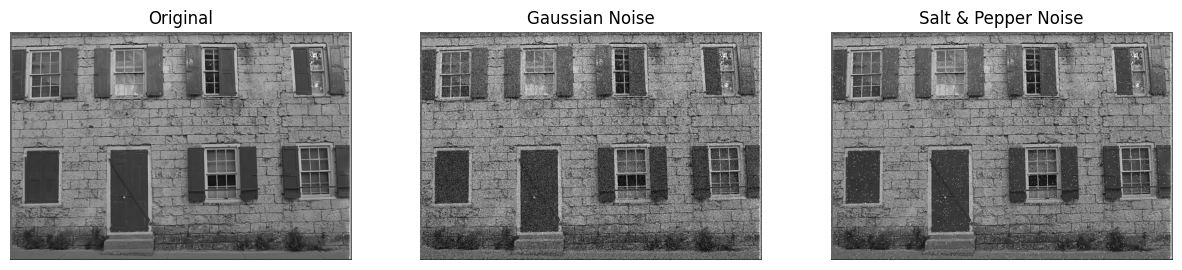

Image sauvegardee → results\noise/gaussian\gaussian_kodim01.png
Image sauvegardee → results\noise/salt_pepper\sp_kodim01.png


In [10]:
# Image grayscale de test
img_gray = load_image(test_img_path, gray=True)

gaussian = add_gaussian_noise(img_gray, var=0.01)
sp = add_salt_pepper_noise(img_gray, amount=0.02)

plt.figure(figsize=(15,5))

# Original
plt.subplot(1,3,1)
plt.imshow(img_gray, cmap='gray')
plt.title("Original")
plt.axis("off")

# Gaussian noise
plt.subplot(1,3,2)
plt.imshow(gaussian, cmap='gray')
plt.title("Gaussian Noise")
plt.axis("off")

# Salt & Pepper
plt.subplot(1,3,3)
plt.imshow(sp, cmap='gray')
plt.title("Salt & Pepper Noise")
plt.axis("off")

plt.show()

# Sauvegarde
base = os.path.basename(test_img_path)
save_image(gaussian, "noise/gaussian", "gaussian_" + base)
save_image(sp, "noise/salt_pepper", "sp_" + base)

## Fonctions des filtres lineaires

In [11]:
def mean_filter(img_gray, k=5):
# Filtre moyenneur (box filter)
    return cv2.blur(img_gray, (k, k))

def gaussian_filter(img_gray, k=5, sigma=1):
#Filtre gaussien
    return cv2.GaussianBlur(img_gray, (k, k), sigma)

### Test des functions

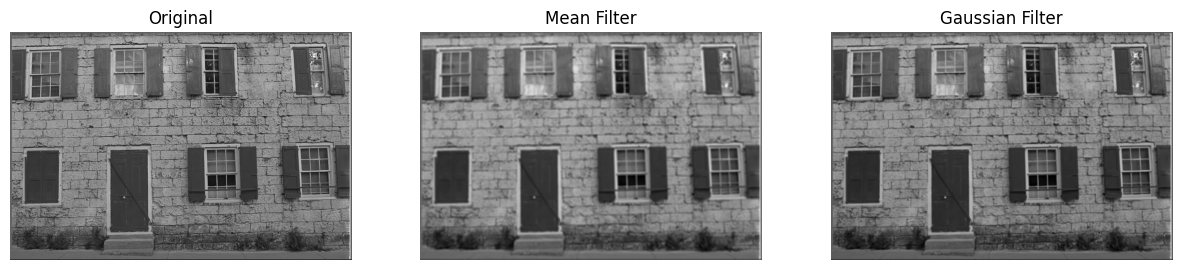

Image sauvegardee → results\filters/mean\mean_kodim01.png
Image sauvegardee → results\filters/gaussian\gaussian_kodim01.png


In [12]:
img_gray = load_image(test_img_path, gray=True)

mean_f = mean_filter(img_gray, k=5)
gauss_f = gaussian_filter(img_gray, k=5, sigma=1)

plt.figure(figsize=(15,5))
plt.subplot(1,3,1); plt.imshow(img_gray, cmap='gray'); plt.title("Original"); plt.axis("off")
plt.subplot(1,3,2); plt.imshow(mean_f, cmap='gray'); plt.title("Mean Filter"); plt.axis("off")
plt.subplot(1,3,3); plt.imshow(gauss_f, cmap='gray'); plt.title("Gaussian Filter"); plt.axis("off")
plt.show()

# Sauvegarde
base = os.path.basename(test_img_path)
save_image(mean_f, "filters/mean", "mean_" + base)
save_image(gauss_f, "filters/gaussian", "gaussian_" + base)


## Fonctions des filtres non lineaires

In [13]:
def median_filter(img_gray, k=5):
# Filtre median
    return cv2.medianBlur(img_gray, k)

def bilateral_filter(img_gray, d=9, sigma_color=75, sigma_space=75):
# Filtre bilateral
    return cv2.bilateralFilter(img_gray, d, sigma_color, sigma_space)

def nagao_filter(img_gray):

# Filtre de Nagao simplifie (version classique)
# Applique plusieurs moyennes régionales et on choisit celle avec variance minimale


    padded = cv2.copyMakeBorder(img_gray, 2, 2, 2, 2, cv2.BORDER_REFLECT)
    result = np.zeros_like(img_gray)

    # 9 regions possibles
    regions = [
        (slice(0,3), slice(0,3)),
        (slice(0,3), slice(1,4)),
        (slice(0,3), slice(2,5)),
        (slice(1,4), slice(0,3)),
        (slice(1,4), slice(1,4)),
        (slice(1,4), slice(2,5)),
        (slice(2,5), slice(0,3)),
        (slice(2,5), slice(1,4)),
        (slice(2,5), slice(2,5)),
    ]

    for i in range(result.shape[0]):
        for j in range(result.shape[1]):
            window = padded[i:i+5, j:j+5]

            variances = []
            means = []

            for region in regions:
                r = window[region]
                variances.append(np.var(r))
                means.append(np.mean(r))

            result[i, j] = means[np.argmin(variances)]

    return result.astype(np.uint8)


### Tests

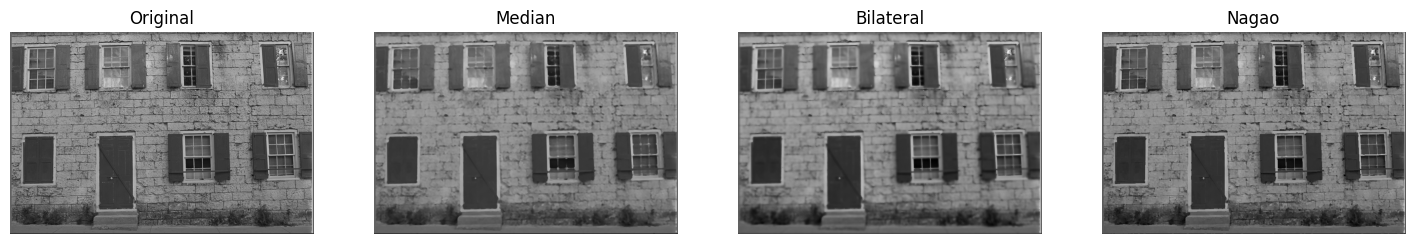

Image sauvegardee → results\filters/median\median_kodim01.png
Image sauvegardee → results\filters/bilateral\bilateral_kodim01.png
Image sauvegardee → results\filters/nagao\nagao_kodim01.png


In [14]:
img_gray = load_image(test_img_path, gray=True)

med = median_filter(img_gray, k=5)
bil = bilateral_filter(img_gray, d=9, sigma_color=75, sigma_space=75)
nag = nagao_filter(img_gray)

plt.figure(figsize=(18,5))
plt.subplot(1,4,1); plt.imshow(img_gray, cmap='gray'); plt.title("Original"); plt.axis("off")
plt.subplot(1,4,2); plt.imshow(med, cmap='gray'); plt.title("Median"); plt.axis("off")
plt.subplot(1,4,3); plt.imshow(bil, cmap='gray'); plt.title("Bilateral"); plt.axis("off")
plt.subplot(1,4,4); plt.imshow(nag, cmap='gray'); plt.title("Nagao"); plt.axis("off")
plt.show()

# Sauvegarde
base = os.path.basename(test_img_path)
save_image(med, "filters/median", "median_" + base)
save_image(bil, "filters/bilateral", "bilateral_" + base)
save_image(nag, "filters/nagao", "nagao_" + base)


## Fonctions de morphologie

In [15]:
def morph_erosion(img_gray, k=3):
    kernel = np.ones((k,k), np.uint8)
    return cv2.erode(img_gray, kernel, iterations=1)

def morph_dilation(img_gray, k=3):
    kernel = np.ones((k,k), np.uint8)
    return cv2.dilate(img_gray, kernel, iterations=1)

def morph_opening(img_gray, k=3):
    kernel = np.ones((k,k), np.uint8)
    return cv2.morphologyEx(img_gray, cv2.MORPH_OPEN, kernel)

def morph_closing(img_gray, k=3):
    kernel = np.ones((k,k), np.uint8)
    return cv2.morphologyEx(img_gray, cv2.MORPH_CLOSE, kernel)

def morph_tophat(img_gray, k=5):
    kernel = np.ones((k,k), np.uint8)
    return cv2.morphologyEx(img_gray, cv2.MORPH_TOPHAT, kernel)

### Tests

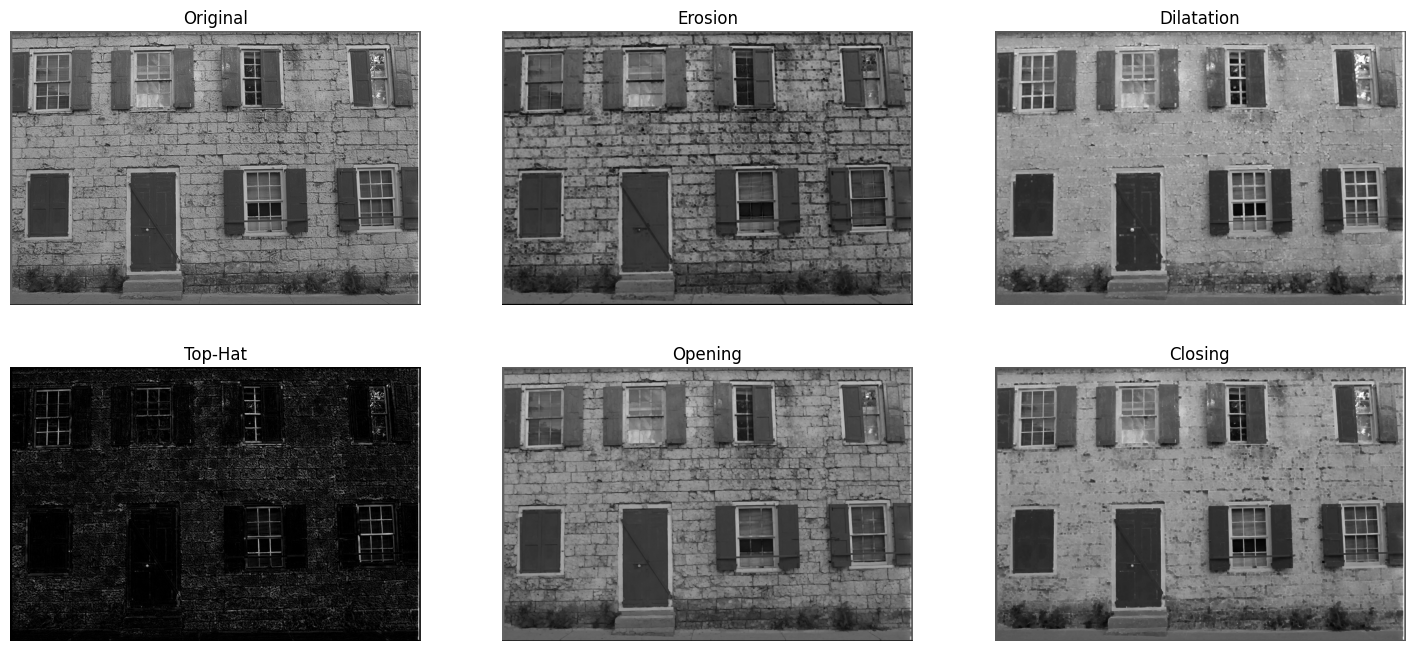

Image sauvegardee → results\morphology/erosion\erosion_kodim01.png
Image sauvegardee → results\morphology/dilation\dilation_kodim01.png
Image sauvegardee → results\morphology/opening\opening_kodim01.png
Image sauvegardee → results\morphology/closing\closing_kodim01.png
Image sauvegardee → results\morphology/tophat\tophat_kodim01.png


In [16]:
img_gray = load_image(test_img_path, gray=True)

er = morph_erosion(img_gray)
di = morph_dilation(img_gray)
op = morph_opening(img_gray)
cl = morph_closing(img_gray)
th = morph_tophat(img_gray)

plt.figure(figsize=(18,8))
plt.subplot(2,3,1); plt.imshow(img_gray, cmap='gray'); plt.title("Original"); plt.axis("off")
plt.subplot(2,3,2); plt.imshow(er, cmap='gray'); plt.title("Erosion"); plt.axis("off")
plt.subplot(2,3,3); plt.imshow(di, cmap='gray'); plt.title("Dilatation"); plt.axis("off")
plt.subplot(2,3,5); plt.imshow(op, cmap='gray'); plt.title("Opening"); plt.axis("off")
plt.subplot(2,3,6); plt.imshow(cl, cmap='gray'); plt.title("Closing"); plt.axis("off")
plt.subplot(2,3,4); plt.imshow(th, cmap='gray'); plt.title("Top-Hat"); plt.axis("off")
plt.show()

# Sauvegarde
base = os.path.basename(test_img_path)
save_image(er, "morphology/erosion", "erosion_" + base)
save_image(di, "morphology/dilation", "dilation_" + base)
save_image(op, "morphology/opening", "opening_" + base)
save_image(cl, "morphology/closing", "closing_" + base)
save_image(th, "morphology/tophat", "tophat_" + base)

# PARTIE : III : Chaines de Traitment

## Fonctions des chaines de traitement

In [17]:
def chain_clahe_gaussian_opening(img_gray, 
                                 clip=3.0, tile=8,
                                 k_gauss=5, sigma=1,
                                 k_open=3):
    
# -- Chaine : CLAHE -> Gaussian Filter -> Opening --

    # 1) CLAHE
    clahe = cv2.createCLAHE(clipLimit=clip, tileGridSize=(tile, tile))
    img_clahe = clahe.apply(img_gray)

    # 2) Gaussian blur
    img_gauss = cv2.GaussianBlur(img_clahe, (k_gauss, k_gauss), sigma)

    # 3) Morphology Opening
    kernel = np.ones((k_open, k_open), np.uint8)
    img_open = cv2.morphologyEx(img_gauss, cv2.MORPH_OPEN, kernel)

    return img_clahe, img_gauss, img_open


def chain_equalization_median_closing(img_gray, 
                                      median_k=5,
                                      closing_k=5):

# -- Chaine : Equalization -> Median filter -> Closing --

    # 1) Equalization
    eq = cv2.equalizeHist(img_gray)

    # 2) Median filter
    med = cv2.medianBlur(eq, median_k)

    # 3) Closing
    kernel = np.ones((closing_k, closing_k), np.uint8)
    close = cv2.morphologyEx(med, cv2.MORPH_CLOSE, kernel)

    return eq, med, close


### Tests

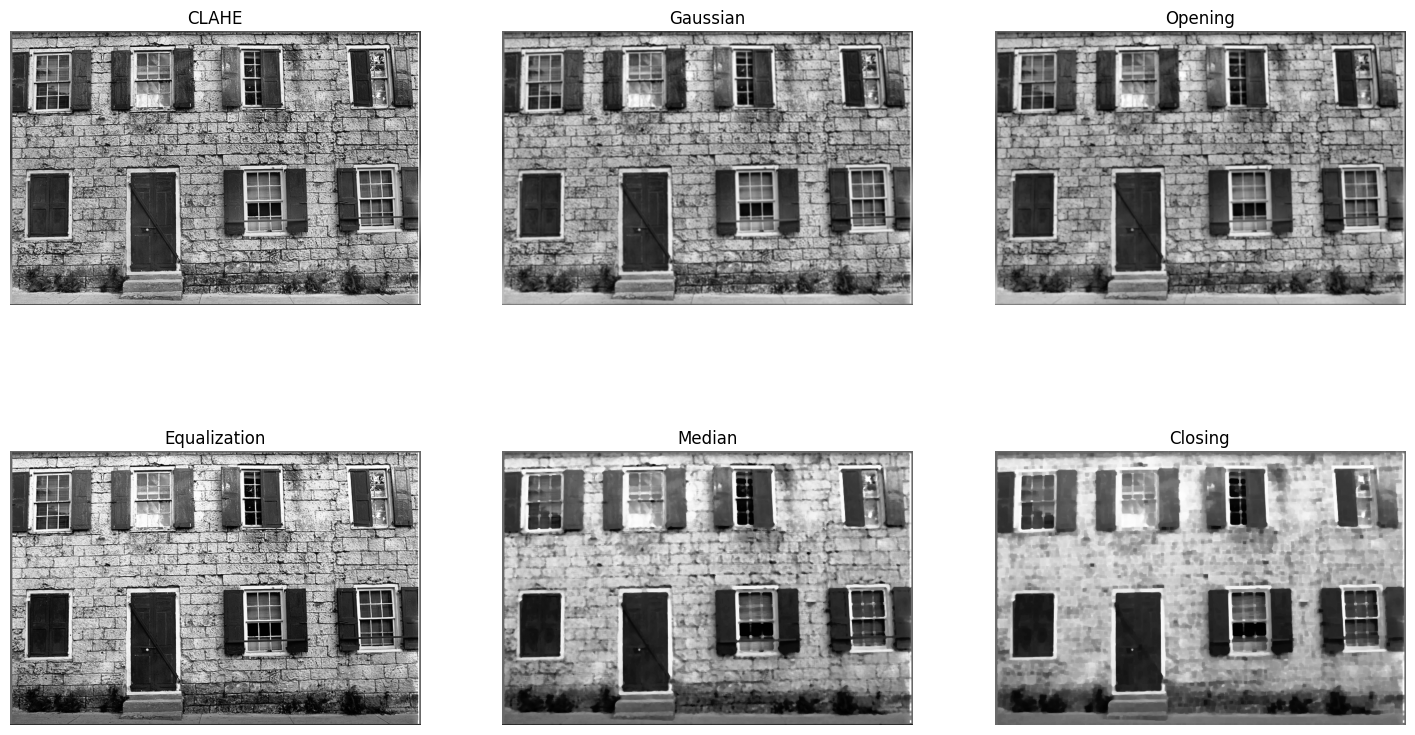

Image sauvegardee → results\chains\CHAIN1_output_kodim01.png
Image sauvegardee → results\chains\CHAIN2_output_kodim01.png


In [18]:
img_gray = load_image(test_img_path, gray=True)

# Chaine 1
clahe_res, gauss_res, open_res = chain_clahe_gaussian_opening(img_gray)

# Chaine 2
eq_res, med_res, close_res = chain_equalization_median_closing(img_gray)

plt.figure(figsize=(18,10))

# Chaine 1
plt.subplot(2,3,1); plt.imshow(clahe_res, cmap='gray'); plt.title("CLAHE"); plt.axis("off")
plt.subplot(2,3,2); plt.imshow(gauss_res, cmap='gray'); plt.title("Gaussian"); plt.axis("off")
plt.subplot(2,3,3); plt.imshow(open_res, cmap='gray'); plt.title("Opening"); plt.axis("off")

# Chaine 2
plt.subplot(2,3,4); plt.imshow(eq_res, cmap='gray'); plt.title("Equalization"); plt.axis("off")
plt.subplot(2,3,5); plt.imshow(med_res, cmap='gray'); plt.title("Median"); plt.axis("off")
plt.subplot(2,3,6); plt.imshow(close_res, cmap='gray'); plt.title("Closing"); plt.axis("off")

plt.show()

# Sauvegarde
base = os.path.basename(test_img_path)
save_image(open_res, "chains", "CHAIN1_output_" + base)
save_image(close_res, "chains", "CHAIN2_output_" + base)


# PARTIE : IV : SEGMENTATION

## Fonctions de segmentation

In [19]:
# -- Segmentation par seuil fixe --
def threshold_global(img_gray, thresh=127):
    _, binary = cv2.threshold(img_gray, thresh, 255, cv2.THRESH_BINARY)
    return binary

# -- Segmentation automatique (OTSU) --
def threshold_otsu(img_gray):
    _, binary = cv2.threshold(img_gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    return binary

# -- Segmentation adaptative locale --
def threshold_adaptive(img_gray, block=11, c=2):
    binary = cv2.adaptiveThreshold(
        img_gray,
        255,
        cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
        cv2.THRESH_BINARY,
        block,
        c
    )
    return binary

### Tests

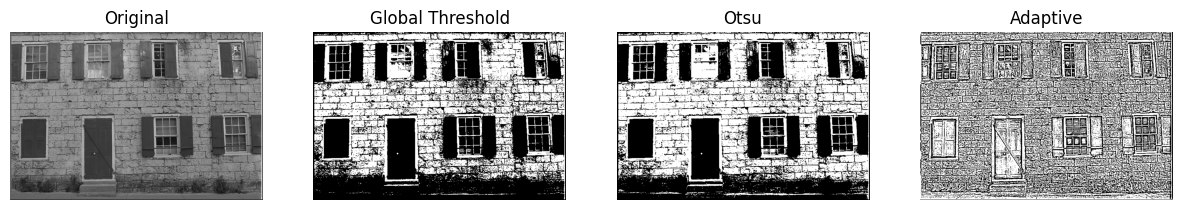

Image sauvegardee → results\segmentation\global_kodim01.png
Image sauvegardee → results\segmentation\otsu_kodim01.png
Image sauvegardee → results\segmentation\adaptive_kodim01.png


In [20]:
img_gray = load_image(test_img_path, gray=True)

seg_global = threshold_global(img_gray, thresh=120)
seg_otsu = threshold_otsu(img_gray)
seg_adapt = threshold_adaptive(img_gray)

plt.figure(figsize=(15,6))

plt.subplot(1,4,1); plt.imshow(img_gray, cmap='gray'); plt.title("Original"); plt.axis("off")
plt.subplot(1,4,2); plt.imshow(seg_global, cmap='gray'); plt.title("Global Threshold"); plt.axis("off")
plt.subplot(1,4,3); plt.imshow(seg_otsu, cmap='gray'); plt.title("Otsu"); plt.axis("off")
plt.subplot(1,4,4); plt.imshow(seg_adapt, cmap='gray'); plt.title("Adaptive"); plt.axis("off")

plt.show()

# Sauvegarde
base = os.path.basename(test_img_path)
save_image(seg_global, "segmentation", "global_" + base)
save_image(seg_otsu, "segmentation", "otsu_" + base)
save_image(seg_adapt, "segmentation", "adaptive_" + base)

# PARTIE : V : Évaluation quantitative

## Fonctions PSNR, SSIM et histogram distance

In [21]:
# Import
from skimage.metrics import structural_similarity as ssim

# PSNR
def compute_psnr(original, processed):
    original = original.astype(np.float32)
    processed = processed.astype(np.float32)
    
    mse = np.mean((original - processed) ** 2)
    if mse == 0:
        return float("inf")

    psnr_value = 20 * np.log10(255.0 / np.sqrt(mse))
    return psnr_value

# SSIM
def compute_ssim(original, processed):
    score, _ = ssim(original, processed, full=True)
    return score

# Distance entre deux histogrammes (chi-square)
def histogram_distance(img1, img2):
    hist1 = cv2.calcHist([img1], [0], None, [256], [0,256])
    hist2 = cv2.calcHist([img2], [0], None, [256], [0,256])
    return cv2.compareHist(hist1, hist2, cv2.HISTCMP_CHISQR)


### Tests

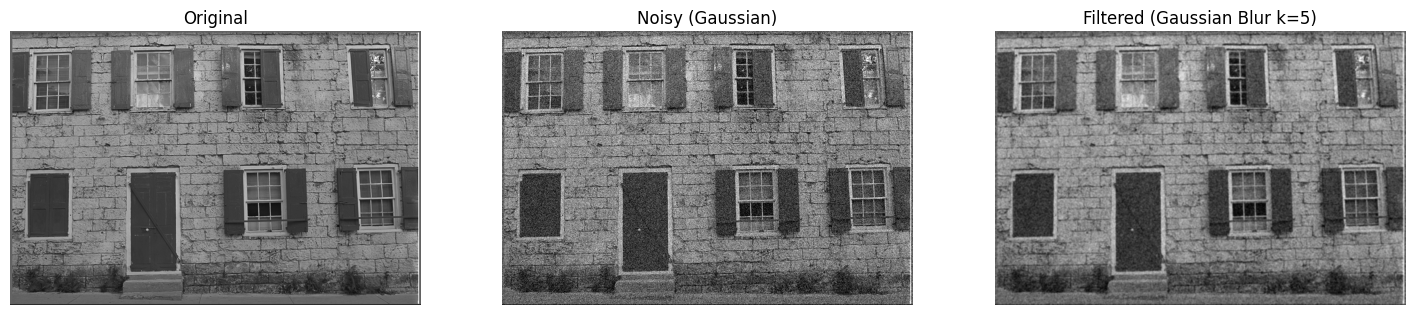

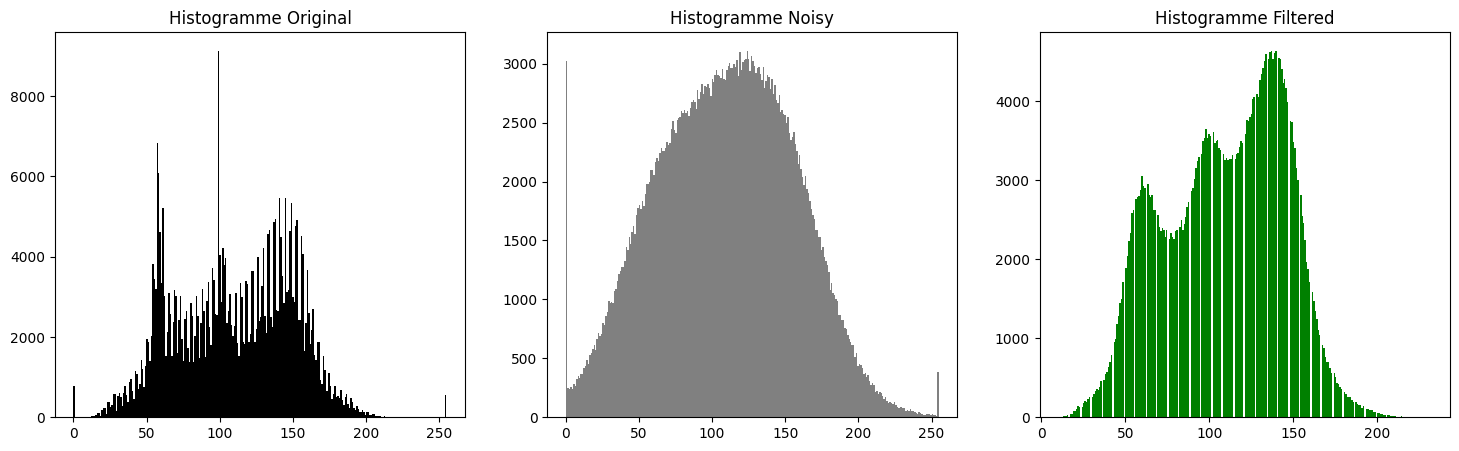

*** METRIQUES ***

PSNR Noisy:     20.0438
PSNR Filtered:  24.3260

SSIM Noisy:     0.5039
SSIM Filtered:  0.6628

Hist Dist Noisy:    432394.6576
Hist Dist Filtered: 67351.9065


Metriques sauvegarde dans : results/metrics_kodim01.txt


In [22]:
img_gray = load_image(test_img_path, gray=True)

# Bruit
noisy = add_gaussian_noise(img_gray, var=0.01)

# Filtrage
filtered = gaussian_filter(noisy, k=5, sigma=1)

# Metriques
psnr_noisy = compute_psnr(img_gray, noisy)
psnr_filtered = compute_psnr(img_gray, filtered)

ssim_noisy = compute_ssim(img_gray, noisy)
ssim_filtered = compute_ssim(img_gray, filtered)

hist_dist_noisy = histogram_distance(img_gray, noisy)
hist_dist_filtered = histogram_distance(img_gray, filtered)

# AFFICHAGE DES IMAGES
plt.figure(figsize=(18,6))

plt.subplot(1,3,1)
plt.imshow(img_gray, cmap='gray')
plt.title("Original")
plt.axis("off")

plt.subplot(1,3,2)
plt.imshow(noisy, cmap='gray')
plt.title("Noisy (Gaussian)")
plt.axis("off")

plt.subplot(1,3,3)
plt.imshow(filtered, cmap='gray')
plt.title("Filtered (Gaussian Blur k=5)")
plt.axis("off")

plt.show()


# LES HISTOGRAMMES

plt.figure(figsize=(18,5))

plt.subplot(1,3,1)
plt.hist(img_gray.ravel(), bins=256, color='black')
plt.title("Histogramme Original")

plt.subplot(1,3,2)
plt.hist(noisy.ravel(), bins=256, color='gray')
plt.title("Histogramme Noisy")

plt.subplot(1,3,3)
plt.hist(filtered.ravel(), bins=256, color='green')
plt.title("Histogramme Filtered")

plt.show()


# AFFICHAGE DES METRIQUES
print("*** METRIQUES ***\n")
print(f"PSNR Noisy:     {psnr_noisy:.4f}")
print(f"PSNR Filtered:  {psnr_filtered:.4f}\n")

print(f"SSIM Noisy:     {ssim_noisy:.4f}")
print(f"SSIM Filtered:  {ssim_filtered:.4f}\n")

print(f"Hist Dist Noisy:    {hist_dist_noisy:.4f}")
print(f"Hist Dist Filtered: {hist_dist_filtered:.4f}")


# SAUVEGARDE DES METRIQUES
metrics_path = "results/metrics_" + os.path.basename(test_img_path).replace(".png", ".txt")

with open(metrics_path, "w") as f:
    f.write("*** METRIQUES ***\n")
    f.write(f"PSNR Noisy:     {psnr_noisy:.6f}\n")
    f.write(f"PSNR Filtered:  {psnr_filtered:.6f}\n\n")
    
    f.write(f"SSIM Noisy:     {ssim_noisy:.6f}\n")
    f.write(f"SSIM Filtered:  {ssim_filtered:.6f}\n\n")
    
    f.write(f"Hist Dist Noisy:    {hist_dist_noisy:.6f}\n")
    f.write(f"Hist Dist Filtered: {hist_dist_filtered:.6f}\n")

print("\n\nMetriques sauvegarde dans :", metrics_path)


# EXTRA PARTIE : VI : Deep Learning

## Fonctions DnCNN + U-Net

Note : "DnCNN : Deep Convolutional Neural Network"

In [23]:
import torch
import torch.nn as nn
import torch.nn.functional as F


# --- ** DnCNN ** ---
class DnCNN(nn.Module):
    def __init__(self, channels=1, num_layers=17, features=64):
        super(DnCNN, self).__init__()
        
        layers = []
        
        # 1ère couche : Conv + ReLU
        layers.append(nn.Conv2d(channels, features, kernel_size=3, padding=1))
        layers.append(nn.ReLU(inplace=True))
        
        # Couches cachées : Conv + BN + ReLU
        for _ in range(num_layers - 2):
            layers.append(nn.Conv2d(features, features, kernel_size=3, padding=1))
            layers.append(nn.BatchNorm2d(features))
            layers.append(nn.ReLU(inplace=True))
        
        # Dernière couche : prédiction du bruit
        layers.append(nn.Conv2d(features, channels, kernel_size=3, padding=1))
        
        self.dncnn = nn.Sequential(*layers)

    def forward(self, x):
        noise = self.dncnn(x)
        return x - noise  # image débruitée

#################################################################

# --- ** U-Net ** ---
class UNet(nn.Module):
    def __init__(self, in_ch=1, out_ch=1):
        super(UNet, self).__init__()

        def conv_block(in_c, out_c):
            return nn.Sequential(
                nn.Conv2d(in_c, out_c, 3, padding=1),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_c, out_c, 3, padding=1),
                nn.ReLU(inplace=True)
            )

        self.enc1 = conv_block(in_ch, 64)
        self.enc2 = conv_block(64, 128)
        self.enc3 = conv_block(128, 256)

        self.pool = nn.MaxPool2d(2)

        self.dec3 = conv_block(256, 128)
        self.dec2 = conv_block(128, 64)
        self.final = nn.Conv2d(64, out_ch, 1)

    def forward(self, x):
        x1 = self.enc1(x)
        x2 = self.enc2(self.pool(x1))
        x3 = self.enc3(self.pool(x2))

        up2 = F.interpolate(x3, scale_factor=2, mode="bilinear")
        d2 = self.dec3(up2)

        up1 = F.interpolate(d2, scale_factor=2, mode="bilinear")
        d1 = self.dec2(up1)

        out = torch.sigmoid(self.final(d1))
        return out



#   fonction utilitaire pour transformer en tensor
def to_tensor(img):

    # img = numpy grayscale image (H,W)
    # return PyTorch tensor (1,1,H,W)

    img = img.astype(np.float32) / 255.0
    return torch.from_numpy(img).unsqueeze(0).unsqueeze(0)




ModuleNotFoundError: No module named 'torch'

### Tests

In [ ]:
img_gray = load_image(test_img_path, gray=True)

# Transformer en tensor
tensor = to_tensor(img_gray)


#    TEST DnCNN

dncnn = DnCNN()
dncnn.eval()

with torch.no_grad():
    denoised = dncnn(tensor).squeeze().numpy()

plt.figure(figsize=(12,4))
plt.subplot(1,3,1); plt.imshow(img_gray, cmap='gray'); plt.title("Original"); plt.axis("off")
plt.subplot(1,3,2); plt.imshow(add_gaussian_noise(img_gray), cmap='gray'); plt.title("Noisy"); plt.axis("off")
plt.subplot(1,3,3); plt.imshow(denoised, cmap='gray'); plt.title("DnCNN Output"); plt.axis("off")
plt.show()



#      TEST U-Net

unet = UNet()
unet.eval()

with torch.no_grad():
    mask = unet(tensor).squeeze().numpy()

plt.figure(figsize=(10,4))
plt.subplot(1,2,1); plt.imshow(img_gray, cmap='gray'); plt.title("Original"); plt.axis("off")
plt.subplot(1,2,2); plt.imshow(mask, cmap='gray'); plt.title("U-Net Segmentation Mask"); plt.axis("off")
plt.show()
